In [2]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from tensorflow import keras as k
import tensorflow as tf
import pathlib 
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization,SeparableConv2D
from warnings import filterwarnings
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.utils import plot_model
filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# VEIWING THE DATASET AND ANALYZING THE DATASET

In [4]:
train_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
test_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"
val_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"

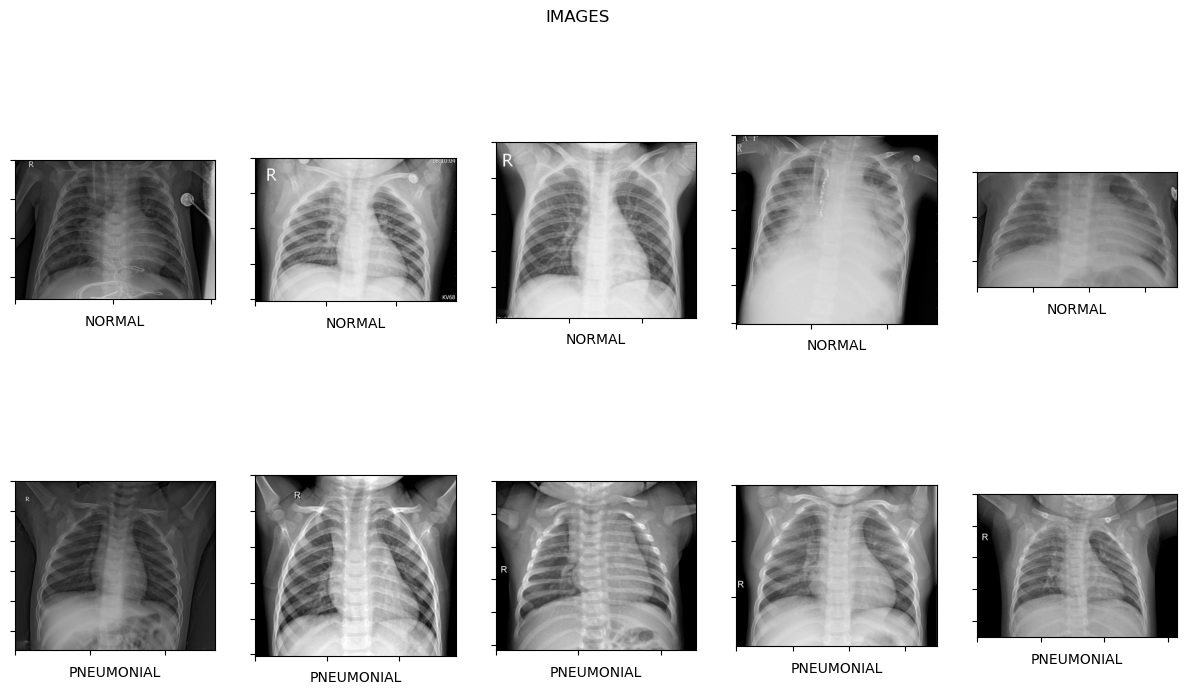

In [5]:
fig,axes = plt.subplots(nrows=2,ncols=5,figsize=(15,8))
train_path = Path(train_path)
paths = list(train_path.iterdir())
normal_train = Path(paths[0])
pneumonia_train = Path(paths[1])
rows=0
cols=0
normal_images = [str(i) for i in normal_train.iterdir()][:5]
diseas_images = [str(i) for i in pneumonia_train.iterdir()][:5]
for i in normal_images:
    img_data = cv.imread(i)
    axes[rows][cols].imshow(img_data)
    axes[rows][cols].axes.set_xticklabels([])
    axes[rows][cols].axes.set_yticklabels([])
    axes[rows][cols].axes.set_xlabel("NORMAL")
    cols+=1
rows+=1
cols=0
for i in diseas_images:
    img_data = cv.imread(i)
    axes[rows][cols].imshow(img_data)
    axes[rows][cols].axes.set_xticklabels([])
    axes[rows][cols].axes.set_yticklabels([])
    axes[rows][cols].axes.set_xlabel("PNEUMONIAL")
    cols+=1
fig.suptitle("IMAGES")
fig.show()

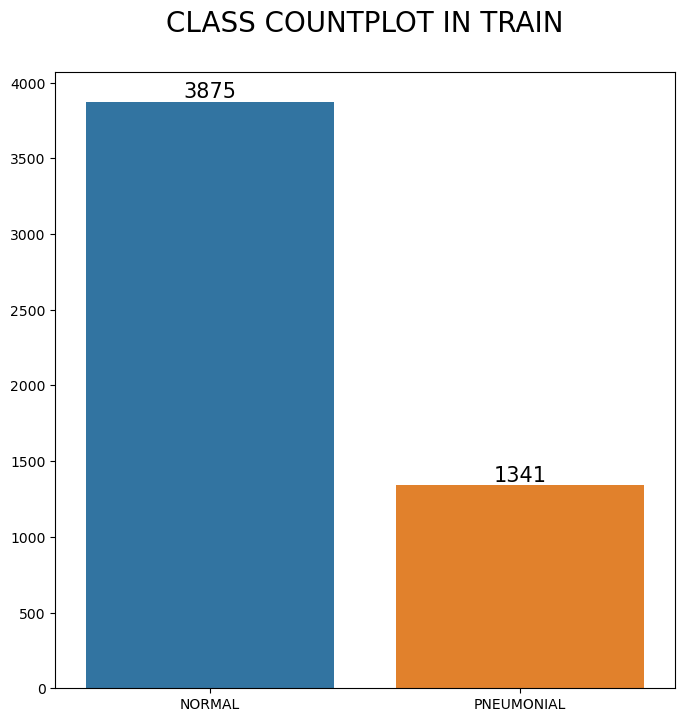

In [6]:
plt.figure(figsize=(8,8))
counts = {"NORMAL":sum(1 for i in normal_train.iterdir()),"PNEUMONIAL":sum(1 for i in pneumonia_train.iterdir())}
ax = sns.barplot(x = list(counts.keys()),y = list(counts.values()))
for i in ax.containers:
    ax.bar_label(i,fontsize=15)
plt.title("CLASS COUNTPLOT IN TRAIN\n",fontsize=20)
plt.show()

# GENERATING AND PREPROCESSING IMAGES

In [8]:
image_generator = k.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

In [9]:
train= image_generator.flow_from_directory(train_path,
                                            batch_size=15,
                                            class_mode="binary",                                           
                                            shuffle=True,
                                            target_size=(224,224))
test = image_generator.flow_from_directory(test_path,
                                            batch_size=15,
                                           class_mode = "binary",                                        
                                            shuffle=True,
                                            target_size=(224,224))
val = image_generator.flow_from_directory(val_path,
                                            batch_size=15,
                                          class_mode = "binary",
                                            shuffle=True, 
                                            target_size=(224,224))

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


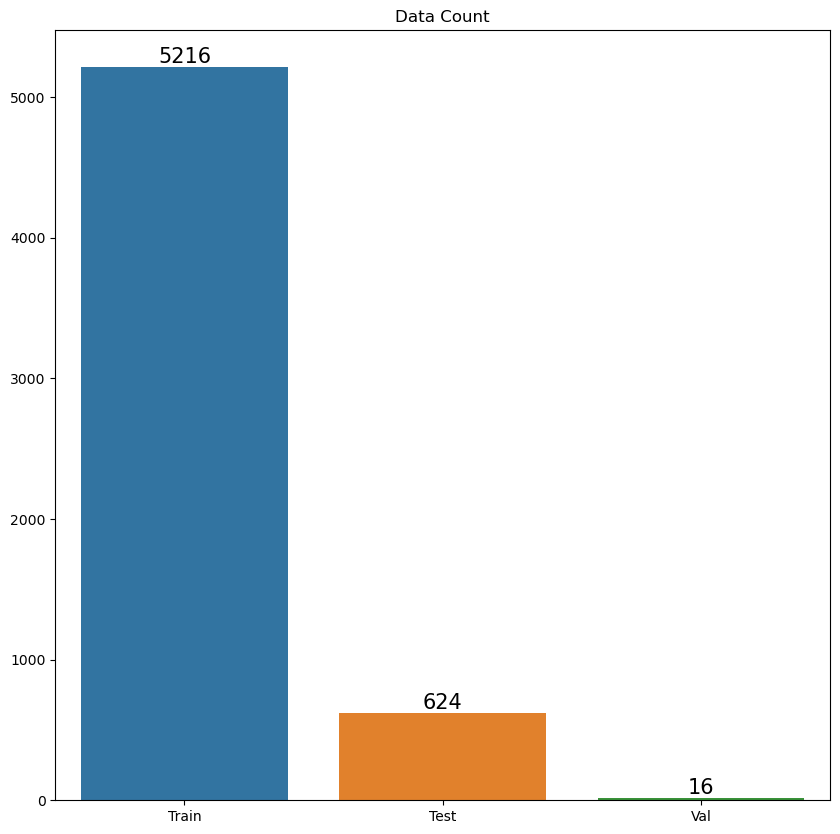

In [10]:
count_images = [train.samples,test.samples,val.samples]
text_count = ['Train','Test','Val']
fig,axes = plt.subplots(nrows=1,ncols=1,figsize = (10,10))
ax = sns.barplot(x = text_count,y=count_images,ax=axes)
for i in ax.containers:
    ax.bar_label(i,fontsize=15)
ax.set_title("Data Count")
plt.show()

In [11]:
train_labels = []
for i in range(len(train)):
    labels = train[i][1]
    train_labels.extend(labels.astype(np.int32))

In [12]:
test_labels = []
for i in range(len(test)):
    labels = test[i][1]
    test_labels.extend(labels.astype(np.int32))

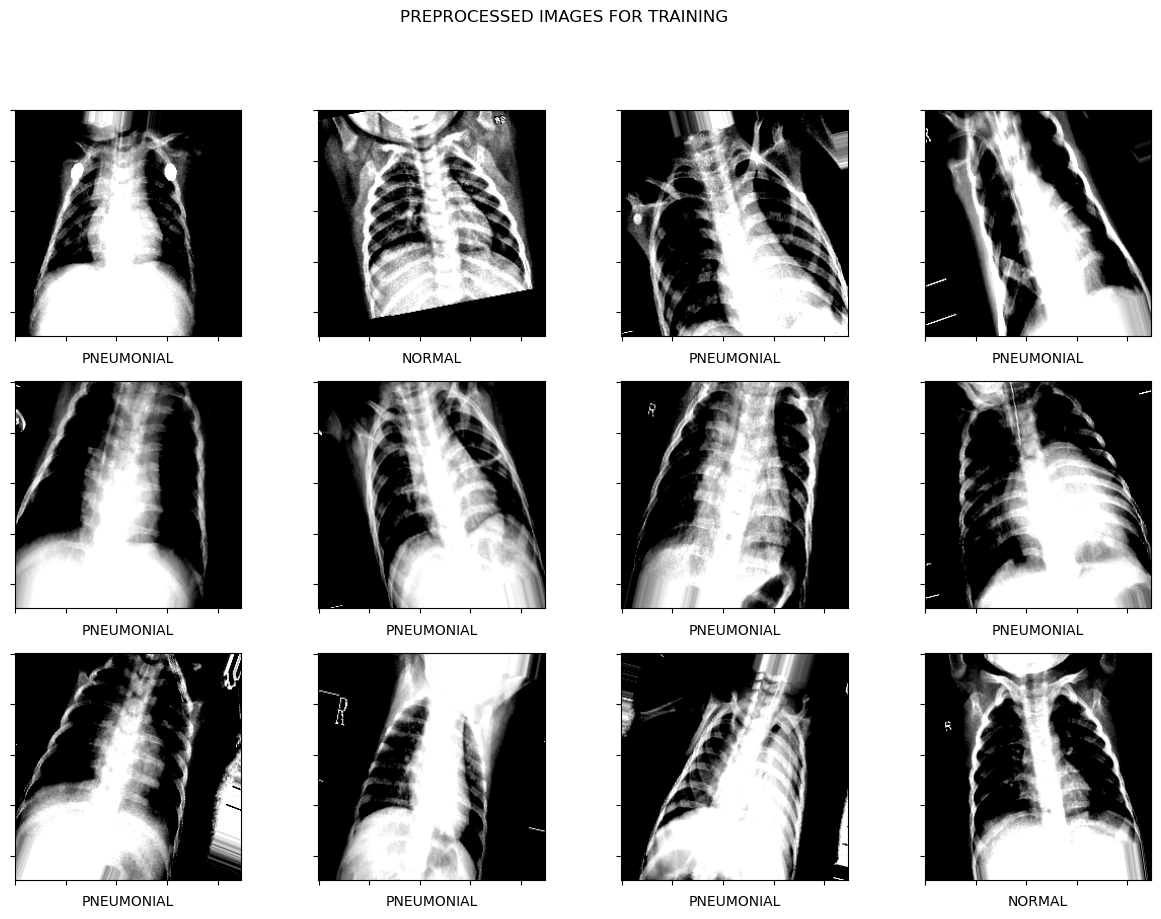

In [13]:
fig,axes = plt.subplots(nrows=3,ncols=4,figsize=(15,10))
labels = {1:"PNEUMONIAL",0:"NORMAL"}
cols=0
rows=0
for i in range(12):
    if i in [4,8]:
        rows+=1
        cols=0
    img_data,label = train.__getitem__(i)
    axes[rows][cols].imshow(img_data[0])
    axes[rows][cols].set_xticklabels([])
    axes[rows][cols].set_yticklabels([])
    axes[rows][cols].set_xlabel(labels[label[0]])
    cols+=1
fig.suptitle("PREPROCESSED IMAGES FOR TRAINING")
fig.show()

In [14]:
img_data,label = train.__getitem__(0)
print(f"The shape of each image in the dataset is {img_data[0].shape}")

The shape of each image in the dataset is (224, 224, 3)


# MODEL FORMULAITION

## MODEL 1

In [16]:
cnn1 = Sequential()
cnn1.add(Conv2D(128, (4, 4), activation="sigmoid", input_shape=(224, 224, 3)))
cnn1.add(Conv2D(128, (4, 4), activation="sigmoid", input_shape=(224, 224, 3)))
cnn1.add(BatchNormalization())
cnn1.add(MaxPool2D(pool_size = (3, 3)))
cnn1.add(Conv2D(64, (3, 3), activation="sigmoid"))
cnn1.add(Conv2D(64, (3, 3), activation="sigmoid"))
cnn1.add(BatchNormalization())
cnn1.add(MaxPool2D(pool_size = (2, 2)))
cnn1.add(Conv2D(32, (3, 3), activation="tanh"))
cnn1.add(Conv2D(32, (3, 3), activation="tanh"))
cnn1.add(BatchNormalization())
cnn1.add(MaxPool2D(pool_size = (2, 2)))
cnn1.add(Flatten())
cnn1.add(Dense(activation = 'tanh', units = 256))
cnn1.add(Dropout(0.2))
cnn1.add(Dense(activation = 'sigmoid', units = 1))
optimizer = k.optimizers.SGD(learning_rate=0.01, momentum=0.9)
cnn1.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy'])
cnn1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 221, 221, 128)     6272      
                                                                 
 conv2d_7 (Conv2D)           (None, 218, 218, 128)     262272    
                                                                 
 batch_normalization_3 (Batc  (None, 218, 218, 128)    512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 72, 72, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 70, 70, 64)        73792     
                                                                 
 conv2d_9 (Conv2D)           (None, 68, 68, 64)       

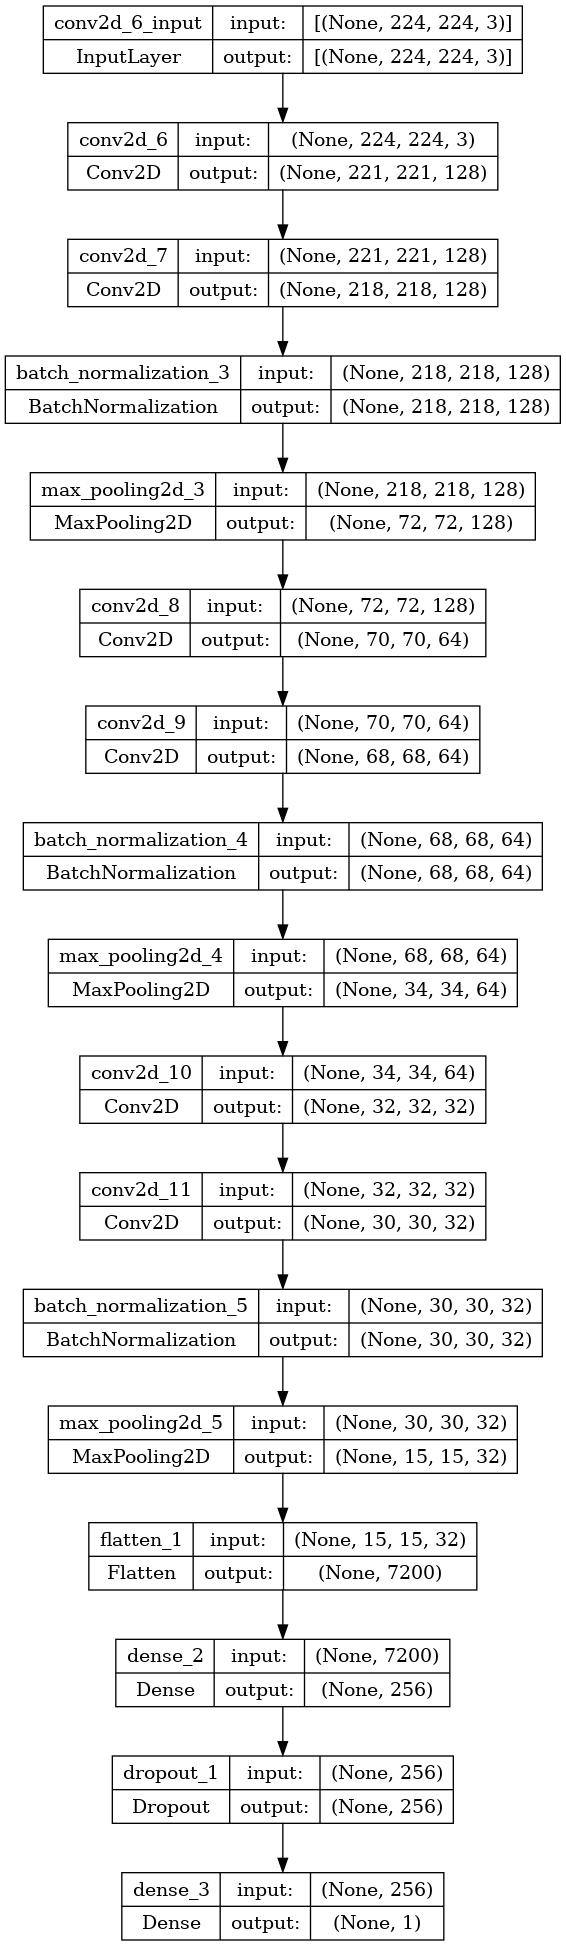

In [17]:
plot_model(cnn1,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [22]:
hist = cnn1.fit_generator(
           train, 
           epochs=5, validation_data=val)

Epoch 1/5
348/348 [==============================] - 161s 410ms/step - loss: 0.4225 - accuracy: 0.8202 - val_loss: 1.4880 - val_accuracy: 0.5625
Epoch 2/5
348/348 [==============================] - 132s 379ms/step - loss: 0.3477 - accuracy: 0.8499 - val_loss: 2.9500 - val_accuracy: 0.5000
Epoch 3/5
348/348 [==============================] - 138s 396ms/step - loss: 0.2841 - accuracy: 0.8806 - val_loss: 5.8339 - val_accuracy: 0.5000
Epoch 4/5
348/348 [==============================] - 131s 375ms/step - loss: 0.2478 - accuracy: 0.8999 - val_loss: 0.8450 - val_accuracy: 0.5000
Epoch 5/5
348/348 [==============================] - 131s 375ms/step - loss: 0.2139 - accuracy: 0.9195 - val_loss: 2.6925 - val_accuracy: 0.6250


In [23]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 18.8 MB/s eta 0:00:0000:01


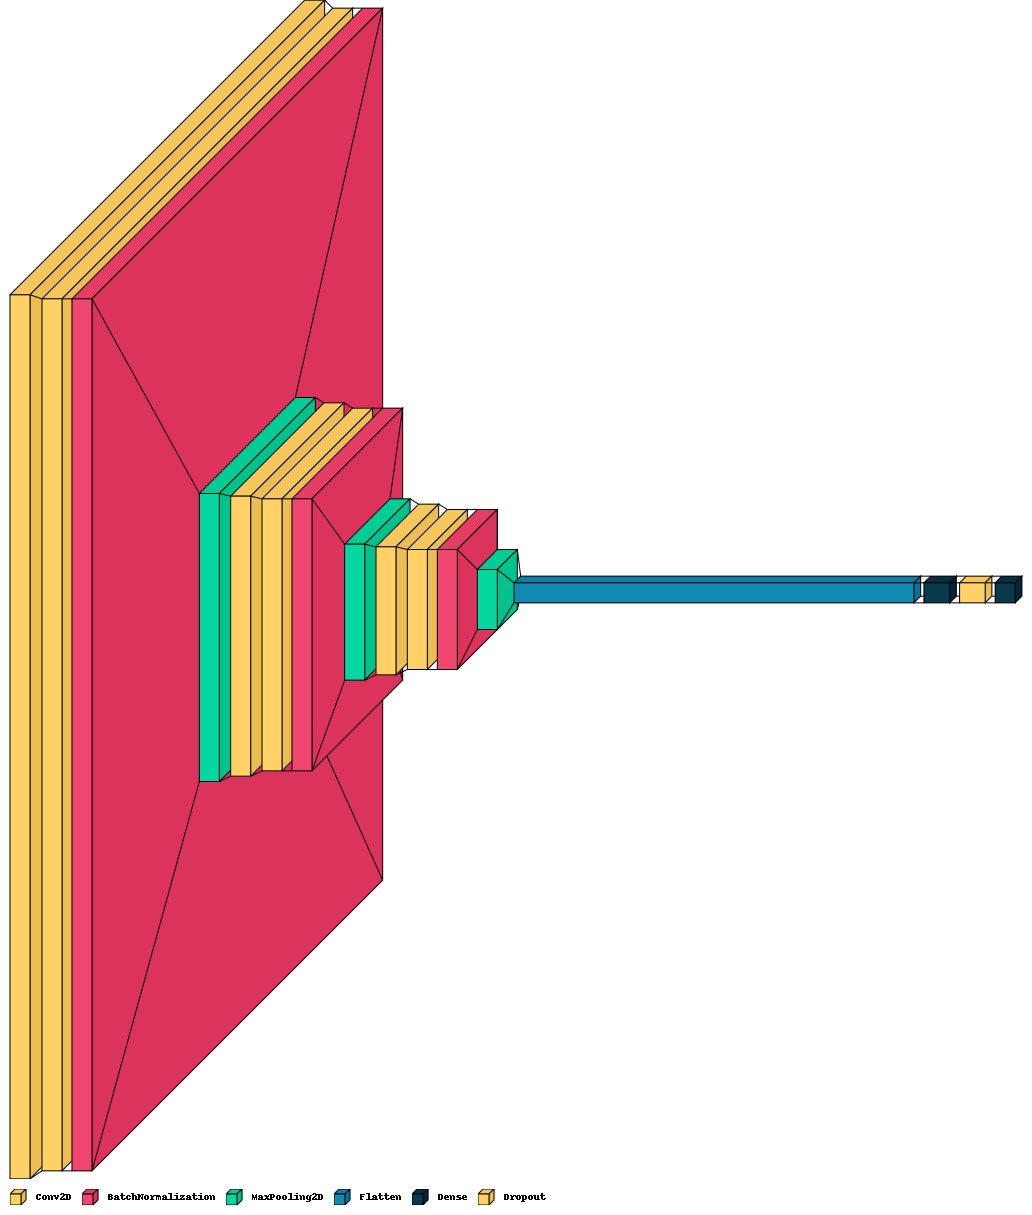

In [27]:
import visualkeras
visualkeras.layered_view(cnn1,legend=True,to_file='cnn1.png')

## MODEL EVALUVATION FOR MODEL 

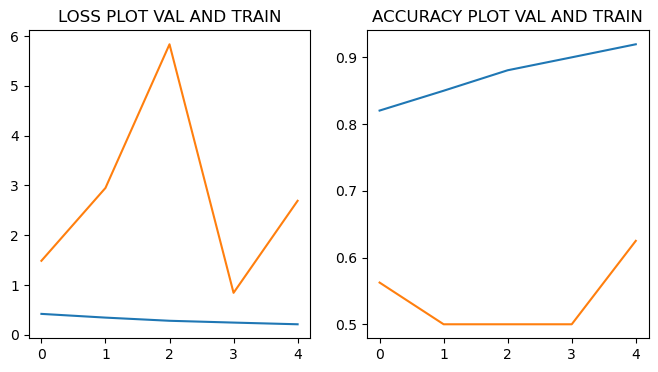

In [28]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
axes[0].plot(hist.history['loss'],label = 'train loss')
axes[0].plot(hist.history['val_loss'],label='validation loss')
axes[0].set_title("LOSS PLOT VAL AND TRAIN")
axes[1].plot(hist.history['accuracy'],label='train accuracy')
axes[1].plot(hist.history['val_accuracy'])
axes[1].set_title("ACCURACY PLOT VAL AND TRAIN")
plt.show()

In [32]:
prediction_test_1=cnn1.evaluate(test)
prediction_train_1 = cnn1.evaluate(train)

348/348 [==============================] - 110s 315ms/step - loss: 0.2341 - accuracy: 0.9258


In [36]:
prediction_test_1[1],prediction_train_1[1] = prediction_test_1[1]*100,prediction_train_1[1]*100

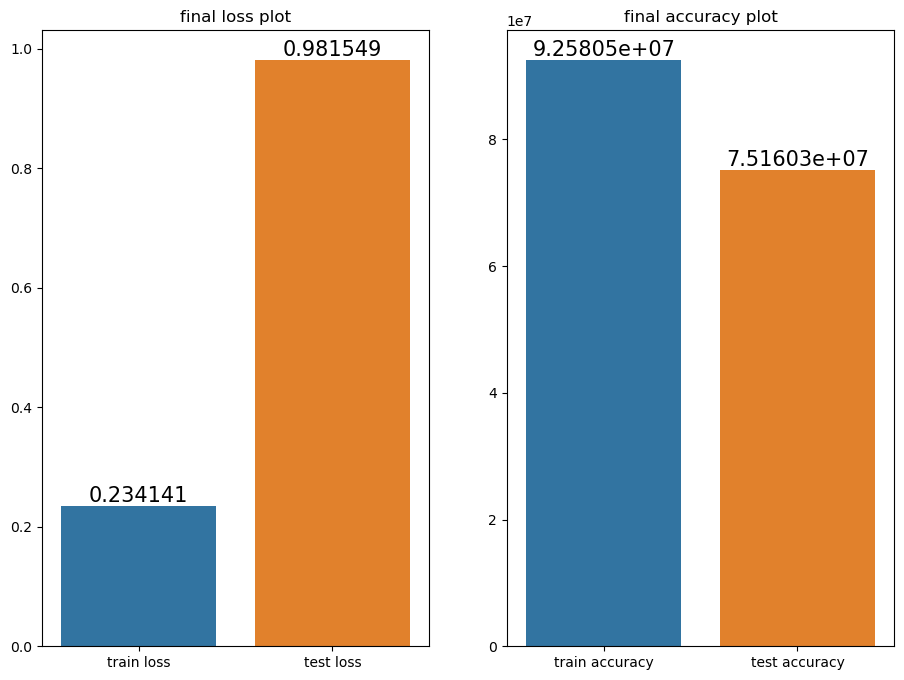

In [37]:
fig,axes = plt.subplots(nrows = 1, ncols = 2,figsize=(11,8))
label_dict = {1:'final accuracy plot',0:'final loss plot'}
axes_label = {1:['train accuracy','test accuracy'],0:['train loss','test loss']}
for i in range(2):
    s = sns.barplot(y=[prediction_train_1[i],prediction_test_1[i]],x=axes_label[i],ax=axes[i])
    for j in s.containers:
        s.bar_label(j,fontsize=15)
    axes[i].set_title(label_dict[i])

## MODEL 2 USING DIFFERENT PARAMETERS AND ACTIVATION FUNCTIONS

In [38]:
cnn = Sequential()
cnn.add(Conv2D(128, (4, 4), activation="relu", input_shape=(224, 224, 3)))
cnn.add(Conv2D(128, (4, 4), activation="relu", input_shape=(224, 224, 3)))
cnn.add(MaxPool2D(pool_size = (3, 3)))
cnn.add(BatchNormalization())
cnn.add(Conv2D(64, (3, 3), activation="relu"))
cnn.add(Conv2D(64, (3, 3), activation="relu"))
cnn.add(MaxPool2D(pool_size = (2, 2)))
cnn.add(BatchNormalization())
cnn.add(Conv2D(32, (3, 3), activation="relu"))
cnn.add(Conv2D(32, (3, 3), activation="relu"))
cnn.add(MaxPool2D(pool_size = (2, 2)))
cnn.add(BatchNormalization())
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 256))
cnn.add(Dropout(0.2))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 221, 221, 128)     6272      
                                                                 
 conv2d_13 (Conv2D)          (None, 218, 218, 128)     262272    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 72, 72, 128)      0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 72, 72, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_14 (Conv2D)          (None, 70, 70, 64)        73792     
                                                                 
 conv2d_15 (Conv2D)          (None, 68, 68, 64)       

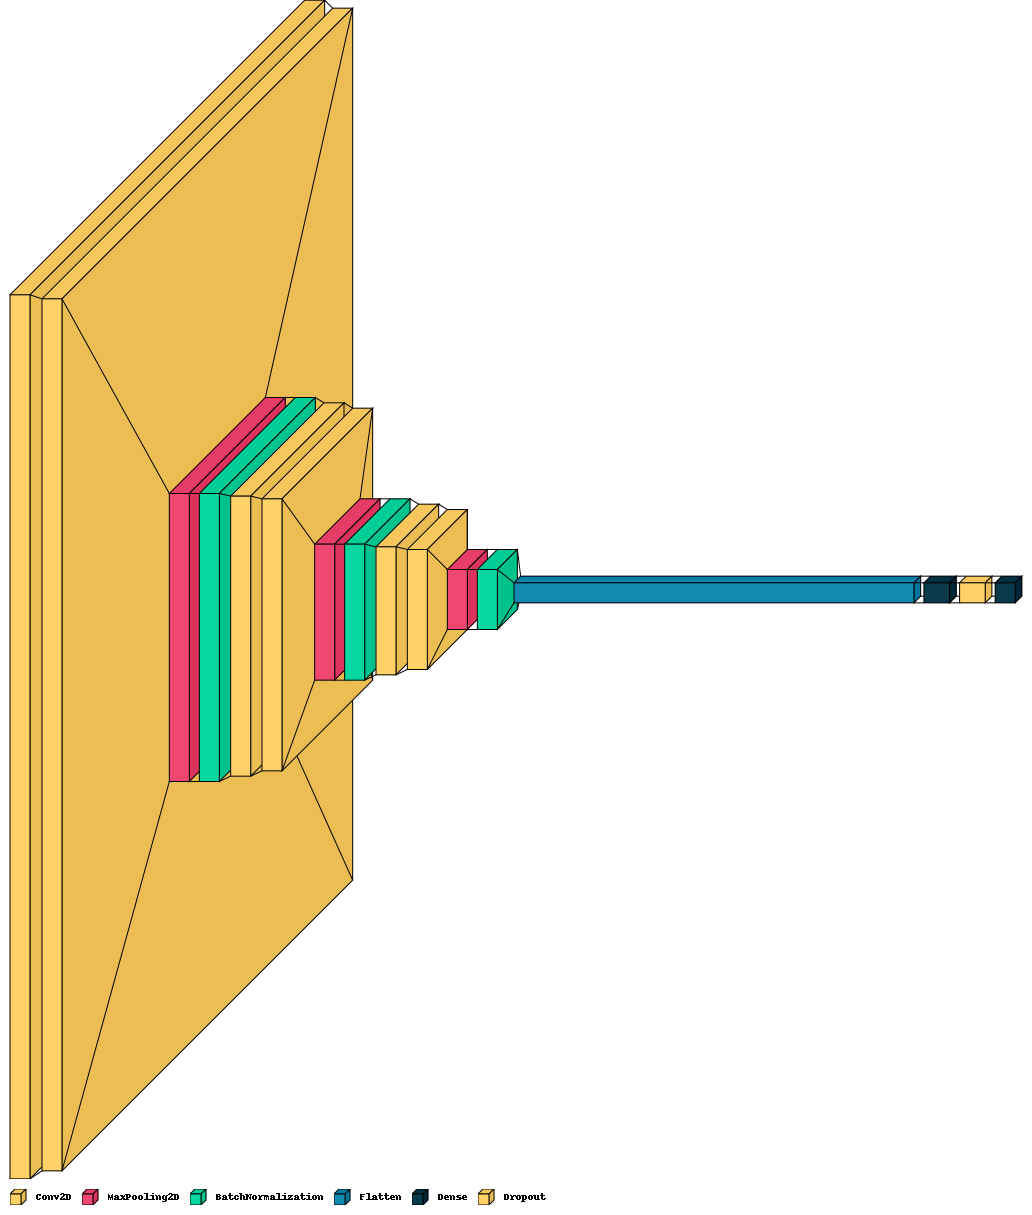

In [54]:
import visualkeras
visualkeras.layered_view(cnn,legend=True,to_file='cnn.png')

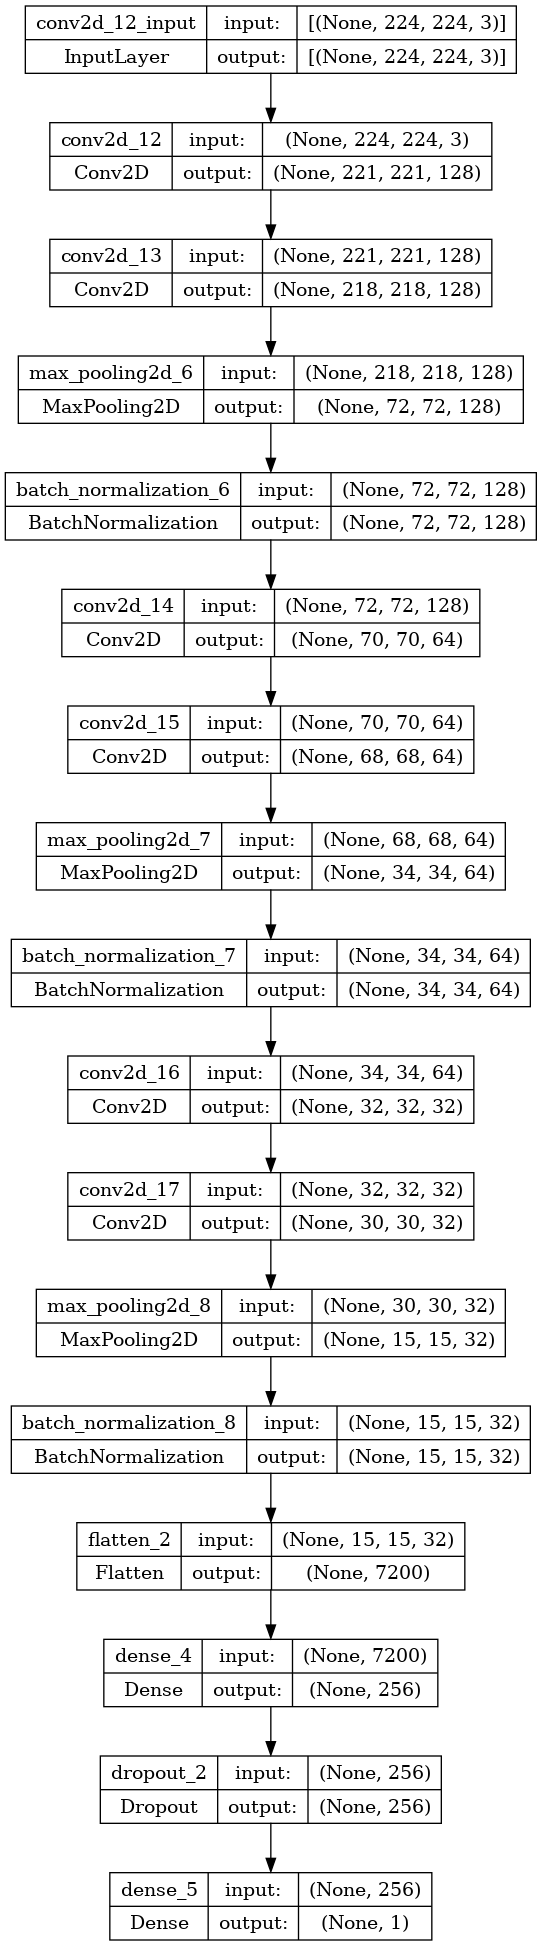

In [44]:
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [47]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [48]:
count_weightage = {0:counts['NORMAL']/(counts['NORMAL']+counts['PNEUMONIAL']),
                  1:counts['PNEUMONIAL']/(counts['NORMAL']+counts['PNEUMONIAL'])}
history = cnn.fit(train,epochs=10,
                  class_weight=count_weightage,
                  validation_data=val)

Epoch 1/10
348/348 [==============================] - 125s 358ms/step - loss: 0.0403 - accuracy: 0.9613 - val_loss: 0.6118 - val_accuracy: 0.8125
Epoch 2/10
348/348 [==============================] - 125s 358ms/step - loss: 0.0370 - accuracy: 0.9611 - val_loss: 0.7473 - val_accuracy: 0.8750
Epoch 3/10
348/348 [==============================] - 128s 367ms/step - loss: 0.0438 - accuracy: 0.9601 - val_loss: 0.3093 - val_accuracy: 0.8750
Epoch 4/10
348/348 [==============================] - 126s 361ms/step - loss: 0.0381 - accuracy: 0.9622 - val_loss: 0.5652 - val_accuracy: 0.7500
Epoch 5/10
348/348 [==============================] - 125s 357ms/step - loss: 0.0379 - accuracy: 0.9626 - val_loss: 0.4727 - val_accuracy: 0.7500
Epoch 6/10
348/348 [==============================] - 125s 358ms/step - loss: 0.0383 - accuracy: 0.9628 - val_loss: 0.9610 - val_accuracy: 0.6250
Epoch 7/10
348/348 [==============================] - 125s 359ms/step - loss: 0.0350 - accuracy: 0.9659 - val_loss: 0.3946 -

## MODEL EVALUVATION FOR MODEL 2

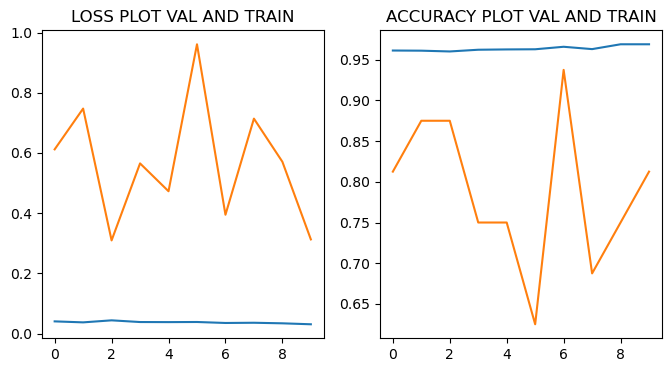

In [49]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
axes[0].plot(history.history['loss'],label = 'train loss')
axes[0].plot(history.history['val_loss'],label='validation loss')
axes[0].set_title("LOSS PLOT VAL AND TRAIN")
axes[1].plot(history.history['accuracy'],label='train accuracy')
axes[1].plot(history.history['val_accuracy'])
axes[1].set_title("ACCURACY PLOT VAL AND TRAIN")
plt.show()

In [50]:
prediction_test=cnn.evaluate(test)
prediction_train = cnn.evaluate(train)

348/348 [==============================] - 107s 307ms/step - loss: 0.0736 - accuracy: 0.9751


In [51]:
prediction_test[1],prediction_train[1] = prediction_test[1]*100,prediction_train[1]*100

In [52]:
cnn.save('Model2.h5')

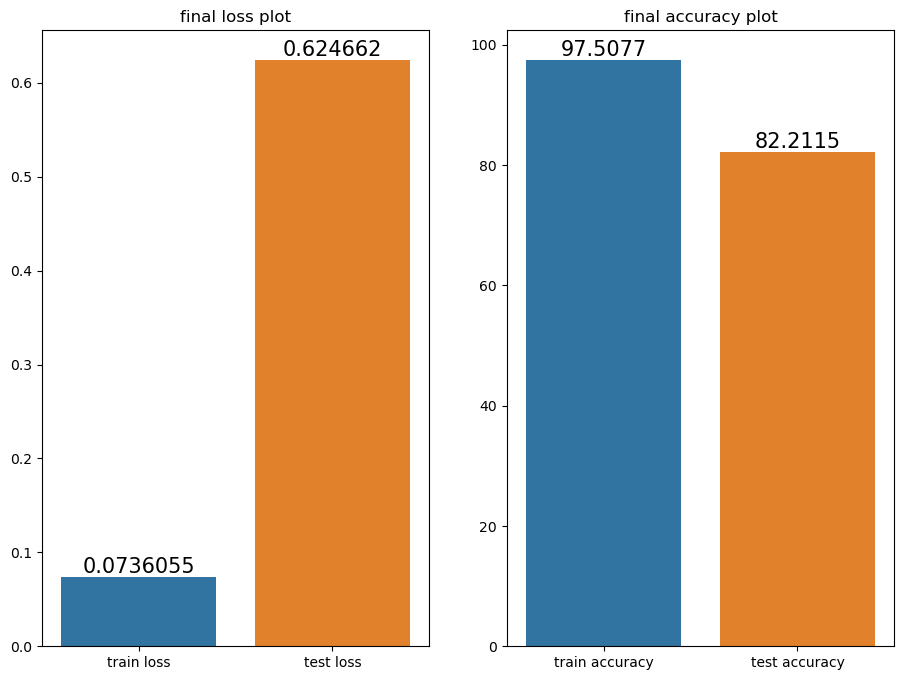

In [53]:
fig,axes = plt.subplots(nrows = 1, ncols = 2,figsize=(11,8))
label_dict = {1:'final accuracy plot',0:'final loss plot'}
axes_label = {1:['train accuracy','test accuracy'],0:['train loss','test loss']}
for i in range(2):
    s = sns.barplot(y=[prediction_train[i],prediction_test[i]],x=axes_label[i],ax=axes[i])
    for j in s.containers:
        s.bar_label(j,fontsize=15)
    axes[i].set_title(label_dict[i])